FINAL DRAFT OF THIS 
Inputs: cdom files 
outputs: wavelenths.csv, plot.png, outputs.csv
    
    the only cells that need edits are at the top 
    they are labled "with edit here"
    
    Hanna Bridgham 
    3/30/2022


In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import numpy as np
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [2]:
#EDIT HERE
####################################
# This returns a list of names (strings) of files that have the .txt extension. 
# You should provide the path
files = glob.glob('../../../CDOM_DATA/GOM21FA/Benthic_chamber/BC_16/*.txt')
# You should add the path of your outputs 
path_1 = '../../../Data_Thesis/CDOM/BC/SPECTRA/ABS_BC_St.16_GOM21FA_Pchip_wavelenths.csv'
path_2 = "../../../Data_Thesis/CDOM/BC/GRAPHS/ABS_BC_St.16_GOM21FA_plot.png"
path_3 = '../../../Data_Thesis/CDOM/BC/OUTPUTS/ABS_BC_St.16_GOM21FA_outputs.csv'
files

['../../../CDOM_DATA/GOM21FA/Benthic_chamber/BC_16\\215542_Absorbance__0__00.txt',
 '../../../CDOM_DATA/GOM21FA/Benthic_chamber/BC_16\\215542_Absorbance__1__01.txt',
 '../../../CDOM_DATA/GOM21FA/Benthic_chamber/BC_16\\215542_Absorbance__2__02.txt',
 '../../../CDOM_DATA/GOM21FA/Benthic_chamber/BC_16\\215543_Absorbance__0__03.txt',
 '../../../CDOM_DATA/GOM21FA/Benthic_chamber/BC_16\\215543_Absorbance__1__04.txt',
 '../../../CDOM_DATA/GOM21FA/Benthic_chamber/BC_16\\215543_Absorbance__2__05.txt',
 '../../../CDOM_DATA/GOM21FA/Benthic_chamber/BC_16\\215544_Absorbance__0__06.txt',
 '../../../CDOM_DATA/GOM21FA/Benthic_chamber/BC_16\\215544_Absorbance__1__07.txt',
 '../../../CDOM_DATA/GOM21FA/Benthic_chamber/BC_16\\215544_Absorbance__2__08.txt',
 '../../../CDOM_DATA/GOM21FA/Benthic_chamber/BC_16\\215545_Absorbance__0__09.txt',
 '../../../CDOM_DATA/GOM21FA/Benthic_chamber/BC_16\\215545_Absorbance__1__10.txt',
 '../../../CDOM_DATA/GOM21FA/Benthic_chamber/BC_16\\215545_Absorbance__2__11.txt',
 '..

In [3]:
#EDIT HERE
####################################
#first Identify what wavegide was used then uncomment the correct waveguide 
#WG 50 #1 : 190987 : 48.9
#WG 50 #2 : 190991 : 48.75
#WG 50 #3 : 192856 : 48.8 

#WG 10 CM 182380 

#X = .489 # 50 cm lwcc number 1 SN: , Basiclly antything from GOM2021 thats not PW
X = .4875 # 50 cm lwcc number 2 SN: , Basiclly antything from GOM21FA thats not PW
#X = .488 # 50 cm lwcc number 3 SN: , Basiclly antything from GOM22SP thats not PW

#X = .01 # Basiclly antything from thats not PW

PART 1: GRAPHS AND WAVELENGTHS 

we use pchip to process the data to get the wavelenths in whole numbers 

we will save this to a output tabel 

we will also save the baseline correction 

In [4]:
#FINAL FUNTION 
#see above for the breakdown of diff parts 
def GET_CDOM_DATA(name):
    df = pd.read_csv(name, skiprows=14, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']*(2.303/X)
    #bcorr = df[(df['wl']>=700) & (df['wl']<=701)]['abs'].mean() # a float corection with just 700 nm 
    #bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float corection with 700 to 750 nm 
    #df['abs'] = df['abs'] - bcorr
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [25]:
#EDIT HERE
####################################
#MAKE IT ALL IN ONE EASY TO USE DATA FRAME 
#this makes a new data frame there all the columns are the scanns and the rows are the wavelths 
#edit the slpit function to get the abs names 
frames = []
for f in files:
    df = GET_CDOM_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df

,215542_Absorbance__0__00.txt,215542_Absorbance__1__01.txt,215542_Absorbance__2__02.txt,215543_Absorbance__0__03.txt,215543_Absorbance__1__04.txt,215543_Absorbance__2__05.txt,215544_Absorbance__0__06.txt,215544_Absorbance__1__07.txt,215544_Absorbance__2__08.txt,215545_Absorbance__0__09.txt,...,215554_Absorbance__0__36.txt,215554_Absorbance__1__37.txt,215554_Absorbance__2__38.txt,215555_Absorbance__0__39.txt,215555_Absorbance__1__40.txt,215555_Absorbance__2__41.txt,215557_Absorbance__0__42.txt,215557_Absorbance__1__43.txt,215557_Absorbance__2__44.txt,Absorbance__0__00-40-36-118.txt
wl,,,,,,,,,,,,,,,,,,,,,
189,-0.001417,-0.020786,-0.017007,-0.024565,0.001417,-0.004724,-0.021258,-0.033541,-0.041572,-0.027400,...,-0.138416,-0.120937,-0.162037,-0.122827,-0.119520,-0.145502,-0.145975,-0.145975,-0.145030,0.005197
190,-0.001417,-0.020786,-0.017007,-0.024565,0.001417,-0.004724,-0.021258,-0.033541,-0.041572,-0.027400,...,-0.138416,-0.120937,-0.162037,-0.122827,-0.119520,-0.145502,-0.145975,-0.145975,-0.145030,0.005197
191,-0.003997,0.012027,-0.006294,0.001197,-0.003061,-0.002714,-0.016093,0.005590,-0.017461,-0.020991,...,-0.126254,-0.148151,-0.117629,-0.104733,-0.150623,-0.145839,-0.137010,-0.138108,-0.138012,0.007537
192,0.039124,0.049841,0.033970,0.026995,0.032188,0.026743,0.011523,0.054056,0.002165,0.003281,...,-0.099696,-0.105630,-0.109902,-0.090948,-0.078316,-0.099964,-0.115506,-0.093124,-0.113440,0.019033
193,-0.004374,-0.027486,-0.021918,-0.020095,-0.021475,-0.037826,-0.042352,-0.050459,-0.049260,-0.067856,...,-0.152125,-0.138560,-0.150356,-0.156609,-0.155516,-0.137994,-0.153575,-0.161779,-0.155528,-0.029742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,-0.037948,-0.022233,-0.044681,-0.017586,-0.069752,-0.046703,-0.029502,-0.031301,-0.023944,-0.031760,...,-0.171464,-0.177499,-0.129239,-0.149625,-0.158457,-0.164498,-0.183809,-0.170734,-0.176838,-0.160209
877,-0.014612,-0.040678,-0.023859,-0.010865,-0.024004,-0.006404,-0.019494,-0.018433,-0.020795,-0.030874,...,-0.148010,-0.136929,-0.128737,-0.142123,-0.149426,-0.153451,-0.193624,-0.160176,-0.152364,-0.152152
878,-0.024619,-0.062553,-0.034001,-0.032915,-0.020885,-0.038723,-0.058269,-0.023751,-0.046711,-0.088853,...,-0.155018,-0.193672,-0.196698,-0.151044,-0.167168,-0.183761,-0.154554,-0.159079,-0.184287,-0.177012


In [26]:
#EDIT HERE
####################################
#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH
#this filters eveything by all that have the work 'Absorbance' with anything after it 
#and turns it into a new object 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
#edit here to make the names a 6 diget number code 
names = d.columns.str.rsplit('_', n=9).str[0]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = d.groupby(names, axis=1).mean()
df

,215542,215543,215544,215545,215546,215547,215548,215549,215550,215551,215552,215553,215554,215555,215557,Absorbance
wl,,,,,,,,,,,,,,,,
189,-0.013070,-0.009291,-0.032124,-0.022361,-0.065822,-0.064405,-0.076216,-0.084246,-0.082199,-0.099364,-0.110859,-0.125819,-0.140463,-0.129283,-0.145660,0.005197
190,-0.013070,-0.009291,-0.032124,-0.022361,-0.065822,-0.064405,-0.076216,-0.084246,-0.082199,-0.099364,-0.110859,-0.125819,-0.140463,-0.129283,-0.145660,0.005197
191,0.000579,-0.001526,-0.009322,-0.024470,-0.052955,-0.058332,-0.059782,-0.064357,-0.077591,-0.090835,-0.106439,-0.126264,-0.130678,-0.133732,-0.137710,0.007537
192,0.040978,0.028642,0.022581,0.003437,-0.019457,-0.016570,-0.040825,-0.036965,-0.046767,-0.046404,-0.063861,-0.088106,-0.105076,-0.089743,-0.107357,0.019033
193,-0.017926,-0.026465,-0.047357,-0.054379,-0.076311,-0.081218,-0.083876,-0.098815,-0.110933,-0.119939,-0.131151,-0.142711,-0.147014,-0.150040,-0.156961,-0.029742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,-0.034954,-0.044680,-0.028249,-0.040364,-0.072330,-0.099572,-0.099394,-0.098701,-0.124702,-0.125471,-0.130621,-0.153899,-0.159401,-0.157526,-0.177127,-0.160209
877,-0.026383,-0.013758,-0.019574,-0.035936,-0.060629,-0.077840,-0.077664,-0.081899,-0.099914,-0.119342,-0.104165,-0.137893,-0.137892,-0.148333,-0.168722,-0.152152
878,-0.040391,-0.030841,-0.042911,-0.077807,-0.099464,-0.115001,-0.096044,-0.098772,-0.122384,-0.137528,-0.156024,-0.161147,-0.181796,-0.167324,-0.165974,-0.177012


In [27]:
bcorr

215542       -0.066812
215543       -0.106246
215544       -0.121212
215545       -0.128875
215546       -0.119929
215547       -0.123699
215548       -0.139919
215549       -0.146431
215550       -0.126595
215551       -0.121027
215552       -0.137012
215553       -0.141539
215554       -0.117499
215555       -0.143228
215557       -0.121301
Absorbance    3.582195
dtype: float64

In [28]:
#HERE WE DO THE BASLINE CORRECTION AND SAVE THE CORECTION AS 'bcorr'
bcorr = df[411:412].mean(axis=0) # 486:537 is 600 nm and this line takes the average 
df = df[:] - df[411:412].mean(axis=0) # here we correct the data by that average 

In [29]:
#HERE WE MAKE A COPY OF THE DATA THAT IS VERTICAL SO JB LIKES IT
Abs_data = df.transpose(copy=False)
Abs_data['bcorr'] = bcorr
Abs_data

#save it as a CSV to the propor location with the correct file name
Abs_data.to_csv(path_1)

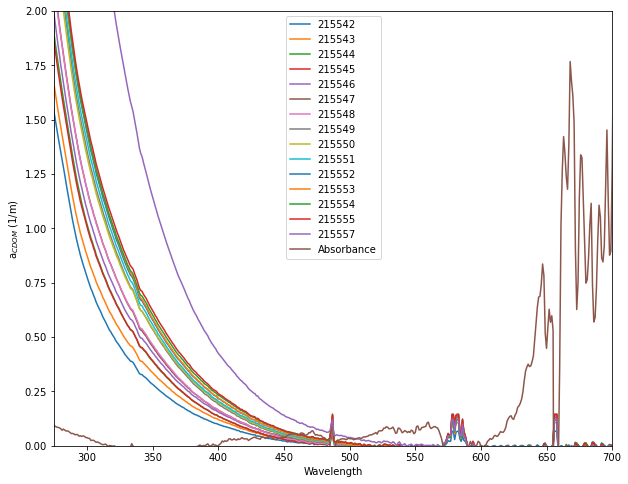

In [34]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-0,2)
ax.set_xlim(275,700)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")

plt.savefig(path_2)

PART 2: REGRESSIONS

I need an output table for each sampling event with the sample number

we will get this with 2 regression methods 

there are two ways we are going to calculate the spectral slopes 
1. Single exponential (SEM) where: $A(g)=Ae^{slope}$
2. Hyperbolic (HM) where: $A(g)=A(\frac{wl}{532})^{slope}$

corresponding parameters = abs 254, abs 280, abs 320, abs 412, abs 444 

corresponding parameters = the spectral slope of 275 to 295, the spectral slope of 350 to 400, the spectral slope of 275 to 700

corresponding parameters = spectral ratio of spectral slope of 275 to 295 and the spectral slope of 350 to 400

corresponding parameters = baseline correction we used, so the b term 


In [11]:
#OPEN OUR FILES AND MAKE ABSORBANCE TO ABSORPTION
def open_file_abs_base_cor(name):
    df = pd.read_csv(name, skiprows=14, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']*(2.303/X)
    return df

In [35]:
#EDIT HERE
####################################
#MAKE IT ALL IN ONE EASY TO USE DATA FRAME 
#this makes a new data frame there all the columns are the scanns and the rows are the wavelths 
frames = []
for f in files:
    df = open_file_abs_base_cor(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 

#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
names = d.columns.str.rsplit('_', n=9).str[0]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = df.groupby(names, axis=1).mean()
df['wl'] = df.index
df

,215542,215543,215544,215545,215546,215547,215548,215549,215550,215551,215552,215553,215554,215555,215557,Absorbance,wl
wl,,,,,,,,,,,,,,,,,
189.2794,-0.013070,-0.009291,-0.032124,-0.022361,-0.065822,-0.064405,-0.076216,-0.084246,-0.082199,-0.099364,-0.110859,-0.125819,-0.140463,-0.129283,-0.145660,0.005197,189.2794
189.6618,-0.013070,-0.009291,-0.032124,-0.022361,-0.065822,-0.064405,-0.076216,-0.084246,-0.082199,-0.099364,-0.110859,-0.125819,-0.140463,-0.129283,-0.145660,0.005197,189.6618
190.0441,-0.013070,-0.009291,-0.032124,-0.022361,-0.065822,-0.064405,-0.076216,-0.084246,-0.082199,-0.099364,-0.110859,-0.125819,-0.140463,-0.129283,-0.145660,0.005197,190.0441
190.4264,0.016534,0.017322,-0.010708,-0.028345,-0.045036,-0.057792,-0.067082,-0.065822,-0.065665,-0.091648,-0.095269,-0.117158,-0.106607,-0.120465,-0.111804,0.008503,190.4264
190.8087,-0.005354,-0.005039,-0.019054,-0.035903,-0.060154,-0.068972,-0.056689,-0.068972,-0.071806,-0.098419,-0.113536,-0.130543,-0.130385,-0.141881,-0.141566,0.006614,190.8087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880.5978,0.001890,0.000315,-0.018424,-0.021416,-0.057319,-0.071964,-0.063618,-0.085979,-0.098576,-0.111016,-0.102041,-0.136212,-0.142038,-0.145660,-0.137471,-0.144558,880.5978
880.8884,-0.008031,-0.017007,-0.009133,-0.042517,-0.060783,-0.065980,-0.075271,-0.077160,-0.088656,-0.113693,-0.110859,-0.119362,-0.135582,-0.131960,-0.141408,-0.168650,880.8884
881.1790,-0.037635,-0.037950,-0.030392,-0.055429,-0.073224,-0.077475,-0.092277,-0.101568,-0.103300,-0.138101,-0.128338,-0.156525,-0.162667,-0.146762,-0.169910,-0.180933,881.1790


In [36]:
#EXPONENTAL REGRESSION A(g)=Ae^slope
def exp_equation(x, a, s, b):
    return a * np.exp(-s * x) + b

In [37]:
#HERE DO THE WHOLE EXPO AS A LOOP FOR ALL SAMPLES 
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #get the x and y values for all the slope intervals we want 
    ydata_s700 = df[(df['wl']>=275) & (df['wl']<=700)][col]
    xdata_s700 = df[(df['wl']>=275) & (df['wl']<=700)]['wl']
    ydata_s700 = np.asarray(ydata_s700, dtype=float).ravel()
    xdata_s700 = np.asarray(xdata_s700, dtype=float).ravel()
    ydata_s295 = df[(df['wl']>=275) & (df['wl']<=295)][col]
    xdata_s295 = df[(df['wl']>=275) & (df['wl']<=295)]['wl']
    ydata_s295 = np.asarray(ydata_s295, dtype=float).ravel()
    xdata_s295 = np.asarray(xdata_s295, dtype=float).ravel()
    ydata_s350 = df[(df['wl']>=350) & (df['wl']<=400)][col]
    xdata_s350 = df[(df['wl']>=350) & (df['wl']<=400)]['wl']
    ydata_s350 = np.asarray(ydata_s350, dtype=float).ravel()
    xdata_s350 = np.asarray(xdata_s350, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams_700 = (15, .001, 0)
    pams_295 = (10, .001, 0)
    pams_350 = (10, .001, 0)
    
    #regression exp_equation 275 to 700
    params, cv = curve_fit(exp_equation, xdata_s700, ydata_s700, p0=pams_700, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 275 to 700 and calcuate rSquared
    squaredDiffs = np.square(ydata_s700 - exp_equation(xdata_s700, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s700 - np.mean(ydata_s700))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_700 = rSquared
    ss_275_700 = s
    
    #get the waveleths we need
    abs_254 = exp_equation(252, a, s, b)
    abs_280 = exp_equation(280, a, s, b)
    abs_320 = exp_equation(320, a, s, b)
    abs_350 = exp_equation(350, a, s, b)
    abs_412 = exp_equation(412, a, s, b)
    abs_440 = exp_equation(440, a, s, b)
    
    #regression exp_equation 275 to 295
    params, cv = curve_fit(exp_equation, xdata_s295, ydata_s295, p0=pams_295, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 270 to 295 and calcuate rSquared
    squaredDiffs = np.square(ydata_s295 - exp_equation(xdata_s295, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s295 - np.mean(ydata_s295))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_295 = rSquared
    ss_275_295 = s
    
    #regression exp_equation 350 to 400
    params, cv = curve_fit(exp_equation, xdata_s350, ydata_s350, p0=pams_350, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 350 to 400 and calcuate rSquared
    squaredDiffs = np.square(ydata_s350 - exp_equation(xdata_s350, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s350 - np.mean(ydata_s350))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_350_400 = rSquared
    ss_350_400 = s 
    
    #get the spectral ratio 
    sr = ss_275_295 / ss_350_400
    
    dict = {'sample':[columnName],
        'ss_275_700_SEM':[ss_275_700],
        'ss_275_295_SEM':[ss_275_295],
        'ss_350_400_SEM':[ss_350_400],
        'R2_275_700':[R2_275_700],
        'R2_275_295':[R2_275_295],
        'R2_350_400':[R2_350_400],
        'SR_SEM':[sr],
        'abs_254_SEM':[abs_254], 
        'abs_280_SEM':[abs_280],
        'abs_320_SEM':[abs_320], 
        'abs_350_SEM':[abs_350],
        'abs_412_SEM':[abs_412], 
        'abs_440_SEM':[abs_440]}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

In [15]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where 

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

R_level = .95 #set x to the r2 value you want to test

min_1 = ss_outs['R2_275_700'].min()
min_2 = ss_outs['R2_275_295'].min()
min_3 = ss_outs['R2_350_400'].min()

if min_1 < R_level: 
    print("!!! WARNING !!! 275_700 has a bad R2 !!!")
if min_2 < R_level:
    print("!!! WARNING !!! 275_295 has a bad R2 !!!")
if min_3 < R_level:
    print("!!! WARNING !!! 350_400 has a bad R2 !!!")
else: 
    print("THE FITS ARE GOOD, YAY!")
    
ss_outs.loc[ss_outs.R2_275_700 < R_level, 'ss_275_700_SEM'] = np.nan
ss_outs.loc[ss_outs.R2_275_295 < R_level, 'ss_275_295_SEM'] = np.nan
ss_outs.loc[ss_outs.R2_350_400 < R_level, 'ss_350_400_SEM'] = np.nan
    
#HERE WE SAME THE SLOPE VALUES 
ss_275_700_SEM = ss_outs['ss_275_700_SEM']
ss_275_295_SEM = ss_outs['ss_275_295_SEM']
ss_350_400_SEM = ss_outs['ss_350_400_SEM']
abs_254_SEM = ss_outs['abs_254_SEM']
abs_280_SEM = ss_outs['abs_280_SEM']
abs_320_SEM = ss_outs['abs_320_SEM']
abs_412_SEM = ss_outs['abs_412_SEM']
abs_440_SEM = ss_outs['abs_440_SEM']
SR_SEM = ss_outs['SR_SEM']

!!! WARNING !!! 275_700 has a bad R2 !!!
!!! WARNING !!! 350_400 has a bad R2 !!!


In [16]:
#HYPERBOLIC REGRESSION A(g)=A(wl/532)^slope
def hyp_equation(x, a, s, b):
    return a * ((x/532)**-s) + b

In [17]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #get the x and y values for all the slope intervals we want 
    #get the x and y values for all the slope intervals we want 
    ydata_s700 = df[(df['wl']>=275) & (df['wl']<=700)][col]
    xdata_s700 = df[(df['wl']>=275) & (df['wl']<=700)]['wl']
    ydata_s700 = np.asarray(ydata_s700, dtype=float).ravel()
    xdata_s700 = np.asarray(xdata_s700, dtype=float).ravel()
    ydata_s295 = df[(df['wl']>=275) & (df['wl']<=295)][col]
    xdata_s295 = df[(df['wl']>=275) & (df['wl']<=295)]['wl']
    ydata_s295 = np.asarray(ydata_s295, dtype=float).ravel()
    xdata_s295 = np.asarray(xdata_s295, dtype=float).ravel()
    ydata_s350 = df[(df['wl']>=350) & (df['wl']<=400)][col]
    xdata_s350 = df[(df['wl']>=350) & (df['wl']<=400)]['wl']
    ydata_s350 = np.asarray(ydata_s350, dtype=float).ravel()
    xdata_s350 = np.asarray(xdata_s350, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams_700 = (.001, 11, 0)
    pams_295 = (1, 0, 1)
    pams_350 = (1, 1, 1)
    
    maxfev = 1000000
    
    #regression exp_equation 275 to 700
    params, cv = curve_fit(hyp_equation, xdata_s700, ydata_s700, p0=pams_700, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 275 to 700 and calcuate rSquared
    squaredDiffs = np.square(ydata_s700 - hyp_equation(xdata_s700, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s700 - np.mean(ydata_s700))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_700 = rSquared
    ss_275_700 = s
    
    #get the waveleths we need
    abs_254 = hyp_equation(252, a, s, b)
    abs_280 = hyp_equation(280, a, s, b)
    abs_320 = hyp_equation(320, a, s, b)
    abs_350 = hyp_equation(350, a, s, b)
    abs_412 = hyp_equation(412, a, s, b)
    abs_440 = hyp_equation(440, a, s, b)
    
    #regression exp_equation 275 to 295
    params, cv = curve_fit(hyp_equation, xdata_s295, ydata_s295, p0=pams_295, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 270 to 295 and calcuate rSquared
    squaredDiffs = np.square(ydata_s295 - hyp_equation(xdata_s295, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s295 - np.mean(ydata_s295))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_295 = rSquared
    ss_275_295 = s
    
    #regression exp_equation 350 to 400
    params, cv = curve_fit(hyp_equation, xdata_s350, ydata_s350, p0=pams_350, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 350 to 400 and calcuate rSquared
    squaredDiffs = np.square(ydata_s350 - hyp_equation(xdata_s350, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s350 - np.mean(ydata_s350))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_350_400 = rSquared
    ss_350_400 = s 
    
    #get the spectral ratio 
    sr = ss_275_295 / ss_350_400
    
    dict = {'sample':[columnName],
        'ss_275_700_HM':[ss_275_700],
        'ss_275_295_HM':[ss_275_295],
        'ss_350_400_HM':[ss_350_400],
        'R2_275_700':[R2_275_700],
        'R2_275_295':[R2_275_295],
        'R2_350_400':[R2_350_400],
        'SR_HM':[sr],
        'abs_254_HM':[abs_254], 
        'abs_280_HM':[abs_280],
        'abs_320_HM':[abs_320], 
        'abs_350_HM':[abs_350],
        'abs_412_HM':[abs_412], 
        'abs_440_HM':[abs_440]}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

In [18]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where 

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

R_level = .95 #set x to the r2 value you want to test

min_1 = ss_outs['R2_275_700'].min()
min_2 = ss_outs['R2_275_295'].min()
min_3 = ss_outs['R2_350_400'].min()

if min_1 < R_level: 
    print("!!! WARNING !!! 275_700 has a bad R2 !!!")
if min_2 < R_level:
    print("!!! WARNING !!! 275_295 has a bad R2 !!!")
if min_3 < R_level:
    print("!!! WARNING !!! 350_400 has a bad R2 !!!")
else: 
    print("THE FITS ARE GOOD, YAY!")

ss_outs.loc[ss_outs.R2_275_700 < R_level, 'ss_275_700_HM'] = np.nan
ss_outs.loc[ss_outs.R2_275_295 < R_level, 'ss_275_295_HM'] = np.nan
ss_outs.loc[ss_outs.R2_350_400 < R_level, 'ss_350_400_HM'] = np.nan
    
    
#HERE WE SAME THE SLOPE VALUES 
ss_275_700_HM = ss_outs['ss_275_700_HM']
ss_275_295_HM = ss_outs['ss_275_295_HM']
ss_350_400_HM = ss_outs['ss_350_400_HM']
abs_254_HM = ss_outs['abs_254_HM']
abs_280_HM = ss_outs['abs_280_HM']
abs_320_HM = ss_outs['abs_320_HM']
abs_412_HM = ss_outs['abs_412_HM']
abs_440_HM = ss_outs['abs_440_HM']
SR_HM = ss_outs['SR_HM']

!!! WARNING !!! 275_700 has a bad R2 !!!
!!! WARNING !!! 350_400 has a bad R2 !!!


PART 3: MAKE ESTIMATE OF INFLECTION 

So at a lot of these there is an infection at around 350 nm 

We need a way to estimate that inflection 

we are going to look for inflections between 300 and 400 nm and quantify them 


In [19]:
#EXPONENTAL REGRESSION A(g)=Ae^slope
def exp_equation(x, a, s, b):
    return a * np.exp(-s * x) + b

In [20]:
#HERE WE FIND THE INTIGRAL OF ALL THE SAMPLE FOR 350 INFLECTION 
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #define where we expect to find the inflection 
    ydata = df[(df['wl']>=300) & (df['wl']<=400)][col]
    xdata = df[(df['wl']>=300) & (df['wl']<=400)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    #here we take evething not in the infelction for the abs data
    ydata_r1 = df[(df['wl']>=250) & (df['wl']<=300)][col]
    ydata_r2 = df[(df['wl']>=400) & (df['wl']<=700)][col]
    ydata_r = pd.concat([ydata_r1, ydata_r2], axis=0)
    
    #here we take evething not in the infelction for the wl data
    xdata_r1 = df[(df['wl']>=250) & (df['wl']<=300)]['wl']
    xdata_r2 = df[(df['wl']>=400) & (df['wl']<=700)]['wl']
    xdata_r = pd.concat([xdata_r1, xdata_r2], axis=0)
    
    #here we make them both arrays so we can doo math 
    ydata_r = np.asarray(ydata_r, dtype=float).ravel()
    xdata_r = np.asarray(xdata_r, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams = (1, .001, 0)
    
    #here we do an expodental fit for just the data where we expect there to de no inflection 
    #aka, what the regression would be without the inflection 
    params, cv = curve_fit(exp_equation, xdata_r, ydata_r, p0=pams, maxfev = maxfev)
    a, s, b = params
    
    #here we calculate the R squared of that regressions fit 
    squaredDiffs = np.square(ydata_r - exp_equation(xdata_r, a, s, b))
    squaredDiffsFromMean = np.square(ydata_r - np.mean(ydata_r))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    
    #here we take the differance of the accual data and the regressions fit that dident have that data 
    diffs = ydata - exp_equation(xdata, a, s, b)
    
    #here we normalize the data 
    diffs = (diffs - np.min(diffs)) / (np.max(diffs) - np.min(diffs))
    
    #here we flaten the data
    y1 = xdata[0]
    y2 = xdata[273]
    x1 = diffs[0]
    x2 = diffs[273]
    m = (x2 - x1)/(y2 - y1)
    mx = m * y1
    b = x1 - mx
    
    diffs = diffs - ((m*xdata)+b)
    
    #here we calculate the intigral 
    inter = scipy.integrate.simps(ydata, x=diffs, even='avg')
    
    #plt.plot(xdata, diffs, 'ko', label='data')
    #plt.plot(xdata, gauss(xdata, *gauss_fit(xdata, diffs)), '--r', label='fit')
    #plt.show()
    #print('The offset of the gaussian baseline is', gaus_baseline)
    #print('The center of the gaussian fit is', center_gaus)
    #print('The sigma of the gaussian fit is', sigma)
    #print('The maximum intensity of the gaussian fit is', H + A)
    #print('The Amplitude of the gaussian fit is', A)
    #print('The FWHM of the gaussian fit is', FWHM)
    
    #here we define some columns for a new data frame with the sample, the R2, and the diffs intigral 
    dict = {'sample':[columnName],
        '350_intergration':[inter],
        'R2':[rSquared]}
    diff = pd.DataFrame(dict)
    
    #here we set the index and append the data together 
    diffs = diff.set_index('sample', drop=True)
    Frames.append(diffs) # adds the new col from each scan to a part of frames 
    
    
diffs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
diffs = diffs.drop('wl') # drops the wl col 

In [21]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where 

diffs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
diffs = diffs.drop('wl') # drops the wl col 

R_level = .95 #set x to the r2 value you want to test

min_1 = diffs['R2'].min()

if min_1 < R_level: 
    print("!!! WARNING !!! 275_700 has a bad R2 !!!")
else: 
    print("THE FITS ARE GOOD, YAY!")

diffs.loc[diffs.R2 < R_level, '350_intergration'] = np.nan

!!! WARNING !!! 275_700 has a bad R2 !!!


In [22]:
#NOW WE SAVE ALL THE VALUSE WE WANTED TO A TABEL 
outputs = pd.concat([ss_275_700_SEM, ss_275_295_SEM, ss_350_400_SEM,
                    ss_275_700_HM, ss_275_295_HM, ss_350_400_HM,
                    abs_254_SEM, abs_280_SEM, abs_320_SEM, abs_412_SEM, abs_440_SEM,
                    abs_254_HM, abs_280_HM, abs_320_HM, abs_412_HM, abs_440_HM,
                    SR_SEM, SR_HM], axis=1)
#outputs = outputs.rename(columns={0: 'baseline_correction', 1: 'abs_254',
#                                  2: 'abs_280', 3: 'abs_320', 4: 'abs_412', 5: 'abs_444'})
outputs['350_intergration'] = diffs['350_intergration']
#SAVE IT 
outputs.to_csv(path_3)
outputs

,ss_275_700_SEM,ss_275_295_SEM,ss_350_400_SEM,ss_275_700_HM,ss_275_295_HM,ss_350_400_HM,abs_254_SEM,abs_280_SEM,abs_320_SEM,abs_412_SEM,abs_440_SEM,abs_254_HM,abs_280_HM,abs_320_HM,abs_412_HM,abs_440_HM,SR_SEM,SR_HM,350_intergration
sample,,,,,,,,,,,,,,,,,,,
215542,0.023061,0.015126,0.019023,7.157395,3.293052,6.090723,2.414944,1.235234,0.451936,-0.003003,-0.032469,2.757862,1.257795,0.437649,0.009212,-0.022307,0.795162,0.540667,NaN
215543,0.021485,0.015499,0.017967,6.696131,3.402709,5.698482,2.479806,1.310864,0.493894,-0.022945,-0.060519,2.829394,1.337157,0.476588,-0.009224,-0.048271,0.862640,0.597125,NaN
215544,0.021296,0.017411,0.018168,6.641016,3.953346,5.774104,2.843984,1.511449,0.574412,-0.024517,-0.068660,3.243138,1.541613,0.554067,-0.008643,-0.054349,0.958294,0.684668,NaN
215545,0.020929,0.018050,0.017880,6.536069,4.134288,5.666091,2.749719,1.471866,0.562449,-0.030646,-0.075542,3.136664,1.502139,0.541876,-0.015093,-0.061245,1.009519,0.729654,NaN
215546,0.020481,0.021450,0.017994,6.400222,5.101647,5.709610,2.913738,1.588775,0.631967,-0.007569,-0.057577,3.317049,1.621574,0.609698,0.009112,-0.041955,1.192094,0.893519,NaN
215547,0.020585,0.021873,0.017950,6.432008,5.218598,5.695267,3.168889,1.725408,0.686539,-0.003890,-0.057472,3.607104,1.760439,0.662385,0.014156,-0.040631,1.218558,0.916304,NaN
215548,0.020282,0.022128,0.018120,6.343049,5.292166,5.755630,3.108771,1.698619,0.673664,-0.018963,-0.073906,3.539808,1.734047,0.649184,-0.001010,-0.056897,1.221190,0.919476,NaN
215549,0.019997,0.018146,0.017913,6.254961,4.153002,5.680348,3.526006,1.948370,0.790962,-0.003575,-0.067911,4.008796,1.988849,0.762847,0.016965,-0.048225,1.013013,0.731118,NaN
215550,0.019608,0.019530,0.016950,6.140884,4.546553,5.322800,3.414846,1.916049,0.802405,0.021260,-0.043788,3.878611,1.956577,0.774459,0.041149,-0.024337,1.152201,0.854166,NaN
